In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
base_keys = list({
                'gACH':(0,0),
                'rDA':(0,0),
                'gDA':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideInIndexnr':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                }.keys())
shortened_keys = [dfh.shorten_col_name(_) for _ in base_keys]

all_alignment_cols = [
                        'SIAA', 'SIAa', 'SIaA', 'SIaa',
                        'SIAB', 'SIAb', 'SIaB', 'SIab',
                        'SIr', 'SInr', 
                     ]
# base_keys

In [5]:
def get_delta_list(event_srs, event_col, keep_srs):
    
    keep_eg_lst = []
    delta_keep_eg_lst = []

    rdc = []
    entry_num = np.arange(len(event_srs))
    event = np.where(event_srs.values == 1)
    assert len(event) == 1
    event = event[0]
    
    for iev, ev in enumerate(event):
        delta = entry_num - ev
        keep_eg = (delta >= -40)&(delta <= 100)&keep_srs
        delta_keep_eg = delta[keep_eg]
        keep_eg_lst.append(keep_eg)
        delta_keep_eg_lst.append(delta_keep_eg)

    return keep_eg_lst, delta_keep_eg_lst

# full_df = h5_lst[0]


In [6]:
# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
#                   ('Figure_3',   'f3*-ft'),
#                   ('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   ('Figure_5_g1',   'f5*-ft'),
#                   ('Figure_5_g2',   'f5*-ft'),
#                   ('Figure_5_g5',   'f5*-ft'),
#                  ]
fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
                  ('Figure_3',   'f3*-ft'),
                  ('Figure_4_g1',   'f4*-ft'),
                  ('Figure_4_g2',   'f4*-ft'),
                  ('Figure_5_g1',   'f5*-ft'),
                  ('Figure_5_g2',   'f5*-ft'),
                  ('Figure_5_g5',   'f5*-ft'),
                 ]

for fig_folder in fig_folder_lst:
    print('fig_folder', fig_folder)
    
    load_folder = base_location / Path(fig_folder[0])
    # load_folder = base_location / Path(r'tmp')
    h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
#     print(h5_recons_locations)
    
#     load_folder = base_location / Path(r'Figure_1_2')
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_3')
#     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g5')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

    out_folder = base_location / Path(r'final_outputs')

    out_loc = str((out_folder).resolve())
    h5_recons_locations = glob.glob(h5_recons_locations)


    h5_lst = defaultdict(dict)
#     run_id_dct = defaultdict(dict)


    for ih5, h5_coef_fn in enumerate(h5_recons_locations):
        h5f = pd.HDFStore(h5_coef_fn)
        h5fk = h5f.keys()
        for ik, key in enumerate(h5fk):
            key = key.replace('/', '')
            resp = key.split('_')[0]
            model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
            

            if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
                continue
            if 'base_simple' not in model_version and 'base_words' not in model_version and '_to_' not in model_version and 'basis' not in key:
                continue
            
#             print('model_version', model_version)
            
#             print(key, model_version)
#             print(f'ih5, ik, model_version, key, h5_coef_fn - {ih5}, {ik}, {model_version}, {key}, {h5_coef_fn}')

            y_col = key.split('_')[0].replace(r'/', r'')
            
            h5_df = pd.read_hdf(h5f, key)

            h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

            if 'dfrel_basis' != key.replace('/', ''):
                h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
                h5_df['true'] = h5_lst[ih5]['dfrel'][y_col]

                h5_df['file_num'] = h5_lst[ih5]['dfrel']['file_num']

                h5_df['dupe'] = h5_lst[ih5]['dfrel']['dupe']
                h5_df['wi_trial_keep'] = h5_lst[ih5]['dfrel']['wi_trial_keep']

                h5_lst[ih5][key] = h5_df
            else:
                h5_lst[ih5]['dfrel'] = h5_df

#     for k in h5_lst:
#         for kk in h5_lst[k]:
#             print(k, kk)



    for ih5 in h5_lst:
#     for y_col in ['gACH', 'rDA', 'gDA']:
#             fig,axes = plt.subplots(5,2,figsize=(10,30))

        combo_rdc = {}
        for iac, alignment_col in enumerate(all_alignment_cols):
#                 ic, ir = iac%2, iac//2
#                 ax = axes[ir, ic]
            
            for key in h5_lst[ih5]:
#             for y_col in ['gACH', 'rDA', 'gDA']:
#             for ih5 in h5_lst:
                if key == 'dfrel':
                    continue
                
                
                resp = key.split('_')[0].replace('/', '')
                model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
                y_col = key.split('_')[0].replace(r'/', r'')
                
                dupe = h5_lst[ih5]['dfrel']['dupe']
                dfrel_basis = h5_lst[ih5]['dfrel'].loc[~dupe]
                dfrel_basis_run = h5_lst[ih5][key].loc[~dupe]

                print('Pulling delta list')
                keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
                rdc_lst = defaultdict(list)
                for entry_num in trange(len(keep_rows)):
                    keep_row_single = keep_rows[entry_num]
                    deltas = assoc_deltas[entry_num]
                    rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

                    if rdc_df['file_num'].nunique() > 1:
                        continue

                    reconstruction_data_list = []

                    for bootstrap_col in ['true', 'pred']:
                        rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

                print('keys', rdc_lst.keys())

                seed = np.random.randint(1000000000)
                for bootstrap_col in (rdc_lst):
                    tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

                    reconstruction_data_list = []
                    for delta in (tmp_rdc.index):
                        row = tmp_rdc.loc[delta].dropna().values
                        bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
    #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
                                                   batch=None, vectorized=True, paired=False,
                                                   axis=0, confidence_level=0.95, method='BCa',
                                                   random_state=seed)

                        mn_val = row.mean()
                        rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

                        reconstruction_data_list.append(rtup)

                    tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
                    combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)

        combo_rdc = pd.concat(combo_rdc, axis=1)
        combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
        combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))


fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_3', 'f3*-ft')
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1240 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/209 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/229 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/29 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/90 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/212 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/126 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1690 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/776 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/3217 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/614 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/375 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/51 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/245 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/485 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/188 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4128 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1596 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_4_g1', 'f4*-ft')
Pulling delta list


  0%|          | 0/5538 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5538 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/560 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/560 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/293 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/293 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/21 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/21 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/235 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/235 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/497 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/497 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/122 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/122 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/6349 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/6349 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1633 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1633 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_4_g2', 'f4*-ft')
Pulling delta list


  0%|          | 0/4546 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4546 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/295 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/295 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/112 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/112 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/819 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/819 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/16 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/16 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/283 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/283 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/470 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/470 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/44 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/44 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5144 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5144 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1441 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1441 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g1', 'f5*-ft')
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4671 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/469 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/129 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/319 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/45 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/331 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/673 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/219 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5518 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1338 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g2', 'f5*-ft')
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/4378 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/412 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/134 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/363 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/38 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/350 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/624 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/156 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5174 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1281 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g5', 'f5*-ft')
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/7278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/902 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/285 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/549 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/76 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/667 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1278 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/509 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8917 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2627 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/8087 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/986 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/317 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/701 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/84 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/751 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1416 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/543 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9904 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2981 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])


In [7]:
combo_rdc

,SIAA_T_lb,SIAA_T_mn,SIAA_T_ub,SIAA_P_lb,SIAA_P_mn,SIAA_P_ub,SIAa_T_lb,SIAa_T_mn,SIAa_T_ub,SIAa_P_lb,...,SIr_T_ub,SIr_P_lb,SIr_P_mn,SIr_P_ub,SInr_T_lb,SInr_T_mn,SInr_T_ub,SInr_P_lb,SInr_P_mn,SInr_P_ub
delta,,,,,,,,,,,,,,,,,,,,,
-40,-0.176349,-0.147634,-0.117567,-0.128361,-0.123217,-0.118047,-0.234214,-0.149367,-0.065013,-0.106298,...,-0.154633,-0.145348,-0.140069,-0.134499,-0.281078,-0.230548,-0.182025,-0.168604,-0.156521,-0.144855
-39,-0.184572,-0.155318,-0.126645,-0.145501,-0.140713,-0.135583,-0.306469,-0.224450,-0.143173,-0.130806,...,-0.158417,-0.156583,-0.151775,-0.146690,-0.284900,-0.236179,-0.188528,-0.171281,-0.160476,-0.149845
-38,-0.171434,-0.142585,-0.113302,-0.160695,-0.156331,-0.151548,-0.254638,-0.173699,-0.093617,-0.155089,...,-0.137358,-0.168333,-0.163873,-0.159380,-0.288815,-0.240155,-0.192528,-0.171215,-0.162042,-0.152580
-37,-0.178563,-0.149153,-0.119021,-0.172420,-0.168076,-0.163468,-0.272567,-0.192893,-0.113152,-0.168672,...,-0.140540,-0.176693,-0.172627,-0.168295,-0.284433,-0.237061,-0.189177,-0.172306,-0.163490,-0.154668
-36,-0.234555,-0.205367,-0.176536,-0.180297,-0.175822,-0.171286,-0.232869,-0.153044,-0.071852,-0.177327,...,-0.186501,-0.182424,-0.178239,-0.173813,-0.278293,-0.232111,-0.185841,-0.175636,-0.166777,-0.158013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.135586,-0.104029,-0.072812,0.010598,0.021088,0.030821,-0.056953,0.032412,0.124870,0.038944,...,-0.074739,0.008727,0.018108,0.027616,0.051491,0.102379,0.151272,0.059891,0.077295,0.095471
97,-0.142329,-0.111027,-0.079940,0.013140,0.023135,0.033291,-0.064586,0.022720,0.110706,0.037431,...,-0.078270,0.010913,0.020287,0.029742,0.047145,0.097170,0.149072,0.057496,0.075231,0.093085
98,-0.120960,-0.089918,-0.058103,0.015135,0.025516,0.035735,-0.060713,0.030923,0.119453,0.042825,...,-0.050676,0.014267,0.023482,0.033132,0.053605,0.104839,0.155278,0.056686,0.074413,0.093126


In [8]:
# for k in h5_lst:
#     for kk in h5_lst[k]:
#         print(k, kk)
# #         display(h5_lst[k][kk])
# #     break

In [9]:
# [len(h5_lst['dfrel'][_]) for _ in range(len(h5_lst['dfrel']))], [len(h5_lst[y_col][_]) for _ in range(len(h5_lst[y_col]))]

In [10]:
# len(dupe), len(h5_lst[y_col][i])

<AxesSubplot:xlabel='delta'>

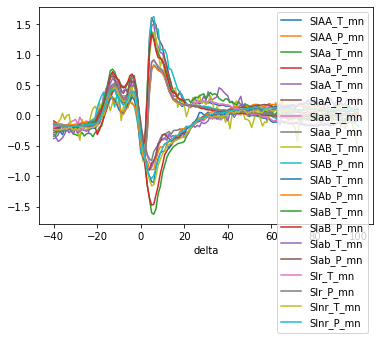

In [11]:
combo_rdc[[_ for _ in combo_rdc.columns if '_mn' in _]].plot()

In [12]:
y_col, model_version

('rDA', 'base_words')

In [13]:
# run_id_dct[y_col]

In [14]:
# # base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
# base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# fig_folder_lst = [#('Figure_1_2', 'f1*-ft'),
#                   #('Figure_3',   'f3*-ft'),
#                   #('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   #('Figure_5_g1',   'f5*-ft'),
#                   #('Figure_5_g2',   'f5*-ft'),
#                   #('Figure_5_g5',   'f5*-ft'),
#                  ]

# for fig_folder in fig_folder_lst:
#     print('fig_folder', fig_folder)
    
#     load_folder = base_location / Path(fig_folder[0])
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
#     print(h5_recons_locations)
    
# #     load_folder = base_location / Path(r'Figure_1_2')
# #     # load_folder = base_location / Path(r'tmp')
# #     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_3')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g5')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

#     out_folder = base_location / Path(r'final_outputs')

#     out_loc = str((out_folder).resolve())
#     h5_recons_locations = glob.glob(h5_recons_locations)


#     h5_lst = defaultdict(list)
#     run_id_dct = defaultdict(list)


#     for h5_coef_fn in h5_recons_locations:
#         h5f = pd.HDFStore(h5_coef_fn)
#         h5fk = h5f.keys()
#         for key in h5fk:

#             resp = key.split('_')[0].replace('/', '')
#             model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]

#             if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
#                 continue
#             if 'base_simple' not in key and 'base_words' not in key and 'basis' not in key:
#                 continue
#             print(key, model_version)

#             y_col = key.split('_')[0].replace(r'/', r'')
#             h5_df = pd.read_hdf(h5f, key)

#             h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

#             if 'dfrel_basis' != key.replace('/', ''):
#                 h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
#                 h5_df['true'] = h5_lst['dfrel'][-1][y_col]
#                 h5_df['resid2'] = (h5_df['true'] - h5_df['pred'])**2

#                 h5_df['file_num'] = h5_lst['dfrel'][-1]['file_num']

#                 h5_df['dupe'] = h5_lst['dfrel'][-1]['dupe']
#                 h5_df['wi_trial_keep'] = h5_lst['dfrel'][-1]['wi_trial_keep']

#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append(model_version)
#             else:
#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append('basis')
#         break
#     break

#     for i in range(2):
#         for y_col in ['gACH', 'rDA', 'gDA']:
# #             fig,axes = plt.subplots(5,2,figsize=(10,30))

#             combo_rdc = {}
#             for iac, alignment_col in enumerate(all_alignment_cols):
# #                 ic, ir = iac%2, iac//2
# #                 ax = axes[ir, ic]

#                 dupe = h5_lst['dfrel'][-1]['dupe']
#                 dfrel_basis = h5_lst['dfrel'][-1].loc[~dupe]
#                 dfrel_basis_run = h5_lst[y_col][i].loc[~dupe]

#                 model_version = run_id_dct[y_col][i]

#                 print('Pulling delta list')
#                 keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
#                 rdc_lst = defaultdict(list)
#                 for entry_num in trange(len(keep_rows)):
#                     keep_row_single = keep_rows[entry_num]
#                     deltas = assoc_deltas[entry_num]
#                     rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

#                     if rdc_df['file_num'].nunique() > 1:
#                         continue

#                     reconstruction_data_list = []

#                     for bootstrap_col in ['true', 'pred']:
#                         rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

#                 print('keys', rdc_lst.keys())

#                 seed = np.random.randint(1000000000)
#                 for bootstrap_col in (rdc_lst):
#                     tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

#                     reconstruction_data_list = []
#                     for delta in (tmp_rdc.index):
#                         row = tmp_rdc.loc[delta].dropna().values
#                         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#     #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
#                                                    batch=None, vectorized=True, paired=False,
#                                                    axis=0, confidence_level=0.95, method='BCa',
#                                                    random_state=seed)

#                         mn_val = row.mean()
#                         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#                         reconstruction_data_list.append(rtup)

#                     tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
#                     combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)

#             combo_rdc = pd.concat(combo_rdc, axis=1)
#             combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
#             combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))


In [15]:
# np.all(h5_lst['dfrel'][0].dropna() == h5_lst['dfrel'][1].dropna())

In [16]:
# h5_lst['dfrel'][0]['rDA']

In [17]:
# h5_df

In [18]:
# h5f

In [19]:
h5_lst.keys()

dict_keys([0, 1, 2])